In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    saltf = datafile.final_salt
    transpf = datafile.final_transp
    lonf = datafile.final_lon
    latf = datafile.final_lat
    depthf = datafile.final_depth
    sectionf = datafile.final_section
    zf = datafile.final_z
    tempf = datafile.final_temp
    
    idx = np.where(sectionf==sectionnum)
    transp_sec = transpf[idx]
    lon_sec = lonf[idx]
    depth_sec = depthf[idx]
    zf_sec = zf[idx]
    salt_sec = saltf[idx]
    temp_sec = tempf[idx]
    
    return {'salt':salt_sec,'transport':transp_sec,'lon':lon_sec,'depth':depth_sec,'z':zf_sec,'temp':temp_sec}

In [27]:
def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,depi,vmax,time,title,cblabel,ylabel):
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,4))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],4)])
    # axv.set_xticklabels(np.round(np.linspace(f_lons[lonW],f_lons[lonE-1],4),2))
    
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')


In [3]:
def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,4))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],4)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')

In [4]:
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

In [5]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

lonW = 308
lonE = 327
latgridi = 300
latgridf = latgridi-1
fmask = mesh.fmask[0, :, latgridi]
tmask = mesh.tmask[0]
    
lons = data.init_lon[(data.final_section != 0)]
    
f_lons = mesh.glamf[0, latgridi]
u_lons = mesh.glamv[0, latgridi]
w_depths = mesh.gdepw_1d

m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

### Importing Data

In [33]:
##Forwards - Eastern JdF
#Jan
datafas = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafds = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/fordec_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafhsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoVS_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafsjvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
datafrsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosVS_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

#July
datafas07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafds07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/fordec_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafhsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafsjvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafrsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

##Backwards
databvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databas = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backADM_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databds = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backdec_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databsjvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databrsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databhsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

#July
databvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databas07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backadm_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databds07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backdec_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databsjvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databrsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databhsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')

##Forwards - SJGI
# Jan
datafg1 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf1_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafg2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf2_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafhspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafsjpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafrspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18_PR/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

# Jul
datafg107 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf1_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafg207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf2_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafhspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafsjpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafrspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

##Backwards
# Jan
databg1 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf1_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databg2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf2_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databhspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databsjpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databrspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backPR_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

# Jul
databg107 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf1_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databg207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf2_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databhspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoPR_jul18/back_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
databsjpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databrspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')

data_dict = {'datafvs':data,'datafas':datafas,'datafds':datafds,'datafrsvs':datafrsvs,'datafsjvs':datafsjvs,'datafhsvs':datafhsvs,
             'datafvs07':datafvs07,'datafas07':datafas07,'datafds07':datafds07,'datafrsvs07':datafrsvs07,'datafsjvs07':datafsjvs07,'datafhsvs07':datafhsvs07,
             'databvs':databvs,'databas':databas,'databds':databds,'databrsvs':databrsvs,'databsjvs':databsjvs,'databhsvs':databhsvs,
             'databvs07':databvs07,'databas07':databas07,'databds07':databds07,'databrsvs07':databrsvs07,'databsjvs07':databsjvs07,'databhsvs07':databhsvs07,
             'datafpr':datafpr,'datafg1':datafg1,'datafg2':datafg2,'datafrspr':datafrspr,'datafsjpr':datafsjpr,'datafhspr':datafhspr,
             'datafpr07':datafpr07,'datafg107':datafg107,'datafg207':datafg207,'datafrspr07':datafrspr07,'datafsjpr07':datafsjpr07,'datafhspr07':datafhspr07,
             'databpr':databpr,'databg1':databg1,'databg2':databg2,'databrspr':databrspr,'databsjpr':databsjpr,'databhspr':databhspr,
             'databpr07':databpr07,'databg107':databg107,'databg207':databg207,'databrspr07':databrspr07,'databsjpr07':databsjpr07,'databhspr07':databhspr07,
}

/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 0.98, 'Salinity - Haro to Rosario')

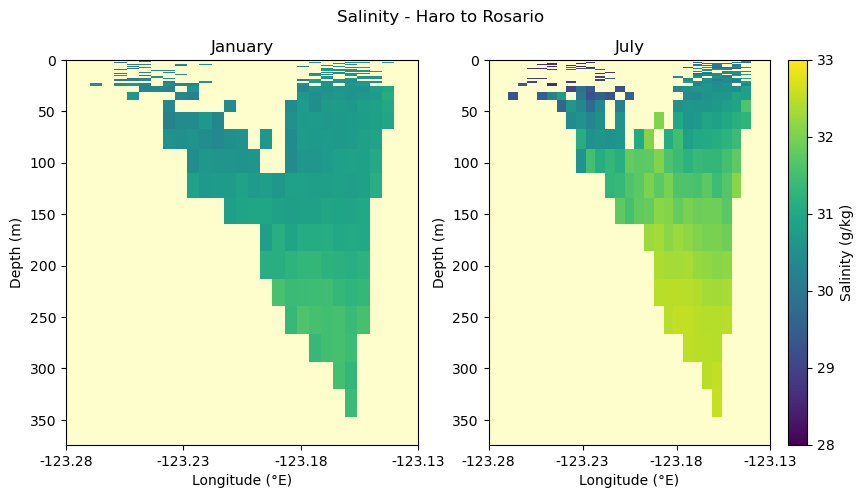

In [21]:
harobrspr07 = get_secdata(databrspr07,6)
harobrspr = get_secdata(databrspr,6)

lonWharo = 215
lonEharo = 245

title = 'January'
title2 = 'July'
time = 168

smin = 28
smax = 33

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax2,'sal',harobrspr07['lon'],harobrspr07['z'],harobrspr07['salt'],lonWharo,lonEharo,38,time,title2,True,True,vmin=smin,vmax=smax)
plotTS(ax1,'sal',harobrspr['lon'],harobrspr['z'],harobrspr['salt'],lonWharo,lonEharo,38,time,title,False,True,vmin=smin,vmax=smax);

fig.suptitle('Salinity - Haro to Rosario')

Saltier deep water from upwelling on WCVI?

/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


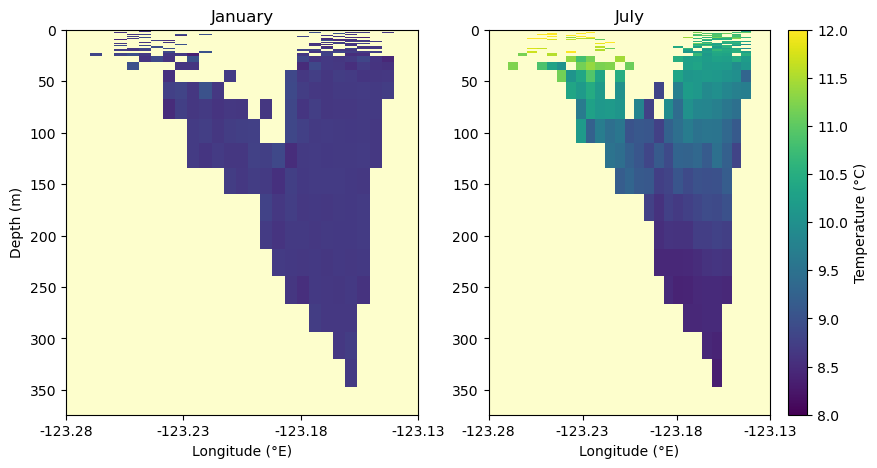

In [25]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

tmin = 8
tmax = 12

plotTS(ax1,'temp',harobrspr['lon'],harobrspr['z'],harobrspr['temp'],lonWharo,lonEharo,38,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'temp',harobrspr07['lon'],harobrspr07['z'],harobrspr07['temp'],lonWharo,lonEharo,38,time,title2,True,False,vmin=tmin,vmax=tmax)

/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


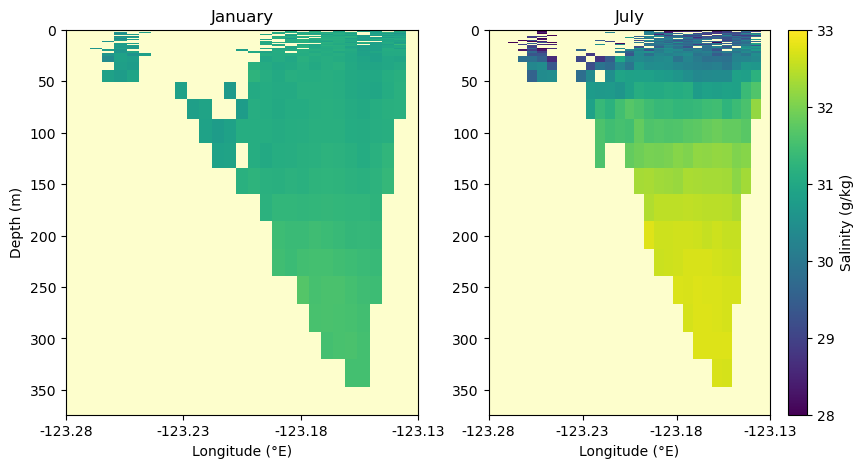

In [17]:
harofvs = get_secdata(data,6)
harofvs07 = get_secdata(datafvs07,6)

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))


plotTS(ax1,'sal',harofvs['lon'],harofvs['z'],harofvs['salt'],lonWharo,lonEharo,38,time,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',harofvs07['lon'],harofvs07['z'],harofvs07['salt'],lonWharo,lonEharo,38,time,title2,True,False,vmin=smin,vmax=smax)

/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


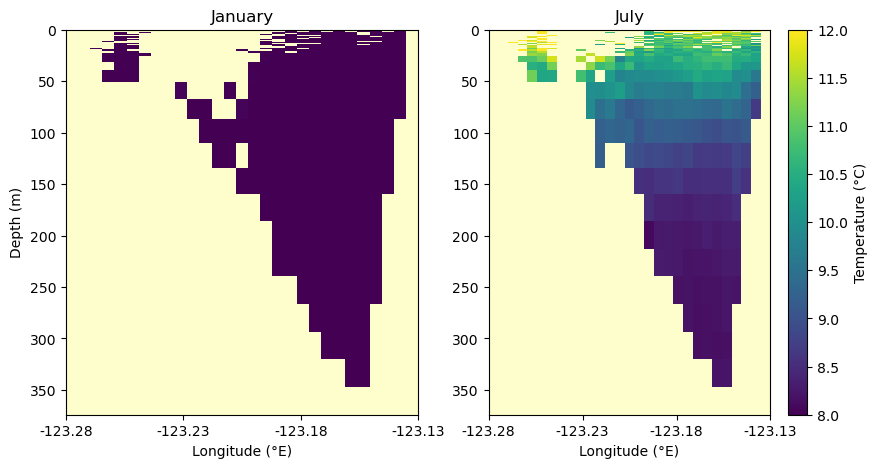

In [26]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'temp',harofvs['lon'],harofvs['z'],harofvs['temp'],lonWharo,lonEharo,38,time,title,False,True,vmin=tmin,vmax=tmax)
plotTS(ax2,'temp',harofvs07['lon'],harofvs07['z'],harofvs07['temp'],lonWharo,lonEharo,38,time,title2,True,False,vmin=tmin,vmax=tmax)

More stratified in July

### Rosario Seeding

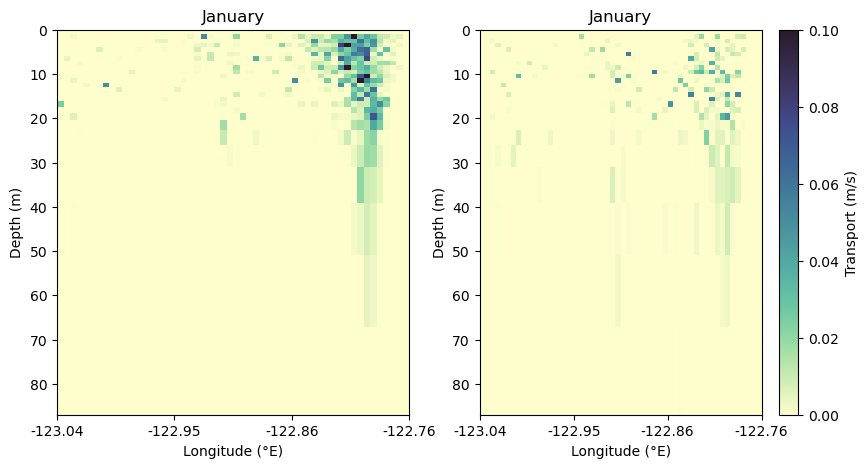

In [38]:
admbrs = get_secdata(databrsvs,2)
admbrs07 = get_secdata(databrsvs07,2)

lonWadm = 260
lonEadm = 315

vmax = 0.1
timeb = 169

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotCS(ax1,admbrs['lon'],admbrs['z'],admbrs['transport'],lonWadm,lonEadm,27,vmax,timeb,title,False,True)
plotCS(ax2,admbrs07['lon'],admbrs07['z'],admbrs07['transport'],lonWadm,lonEadm,27,vmax,timeb,title,True,True)

/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


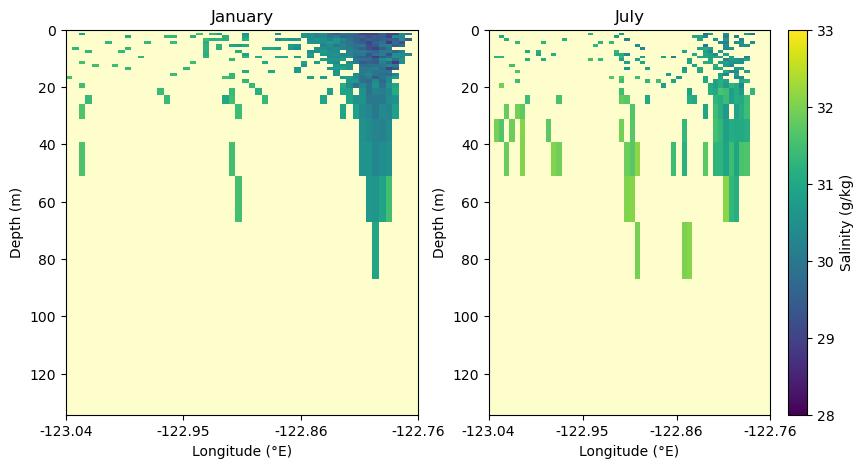

In [42]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'sal',admbrs['lon'],admbrs['z'],admbrs['salt'],lonWadm,lonEadm,29,timeb,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',admbrs07['lon'],admbrs07['z'],admbrs07['salt'],lonWadm,lonEadm,29,timeb,title2,True,True,vmin=smin,vmax=smax)

#### Admiralty to Haro

/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


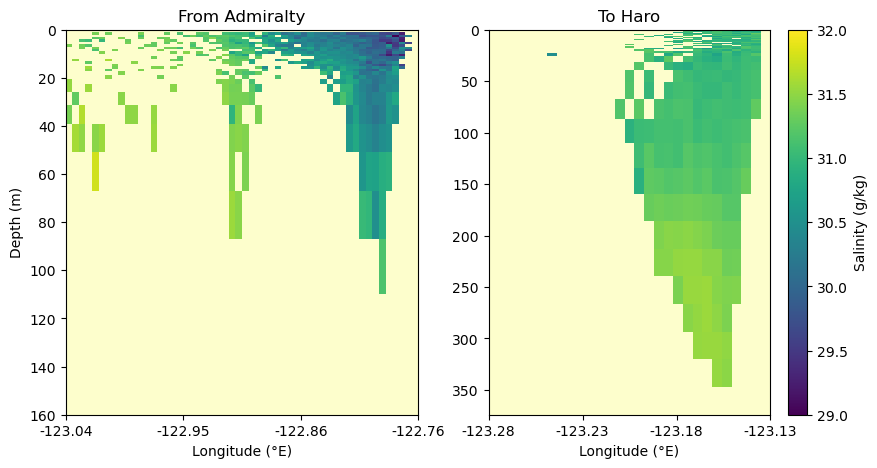

In [52]:
admbhs = get_secdata(databhsvs,2)
harofas = get_secdata(datafas,6)

title = 'To Haro'
title2 = 'From Admiralty'

smin = 29
smax = 32

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'sal',admbhs['lon'],admbhs['z'],admbhs['salt'],lonWadm,lonEadm,30,timeb,title2,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',harofas['lon'],harofas['z'],harofas['salt'],lonWharo,lonEharo,38,time,title,True,False,vmin=smin,vmax=smax)

/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


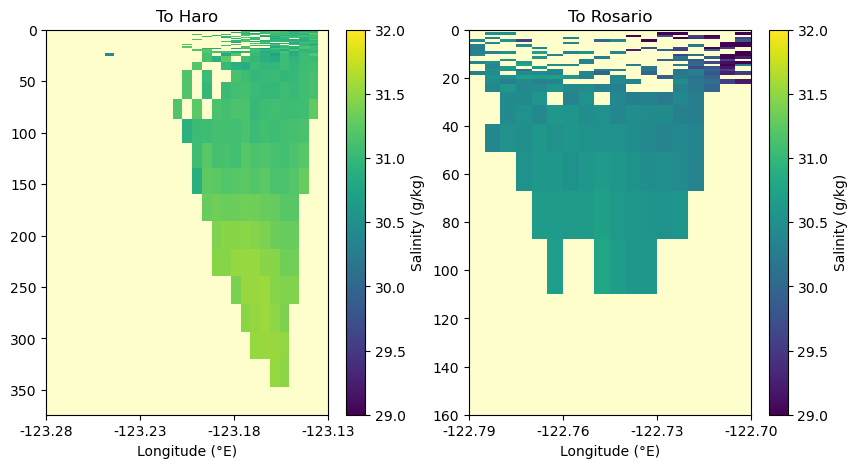

In [48]:
rosfas = get_secdata(datafas,4)
admbrs = get_secdata(databrsvs,2)
title = 'To Haro'
title2 = 'To Rosario'

lonWros=308
lonEros=327

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'sal',harofas['lon'],harofas['z'],harofas['salt'],lonWharo,lonEharo,38,time,title,True,False,vmin=smin,vmax=smax)
plotTS(ax2,'sal',rosfas['lon'],rosfas['z'],rosfas['salt'],lonWros,lonEros,30,time,title2,True,False,vmin=smin,vmax=smax)

/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


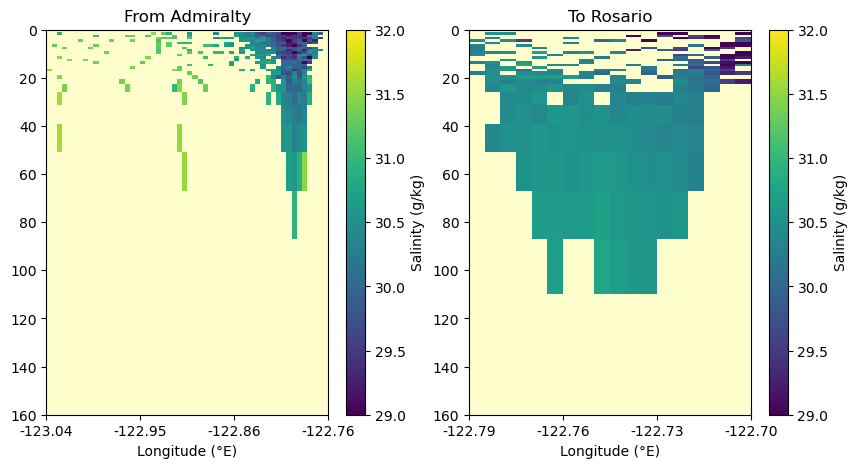

In [49]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

title = 'From Admiralty'
title2 = 'To Rosario'

plotTS(ax1,'sal',admbrs['lon'],admbrs['z'],admbrs['salt'],lonWadm,lonEadm,30,timeb,title,True,False,vmin=smin,vmax=smax)
plotTS(ax2,'sal',rosfas['lon'],rosfas['z'],rosfas['salt'],lonWros,lonEros,30,time,title2,True,False,vmin=smin,vmax=smax)

Fresher entering Rosario than Haro (properties more modified in journey to Haro)

/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_15633/1186497930.py:10: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


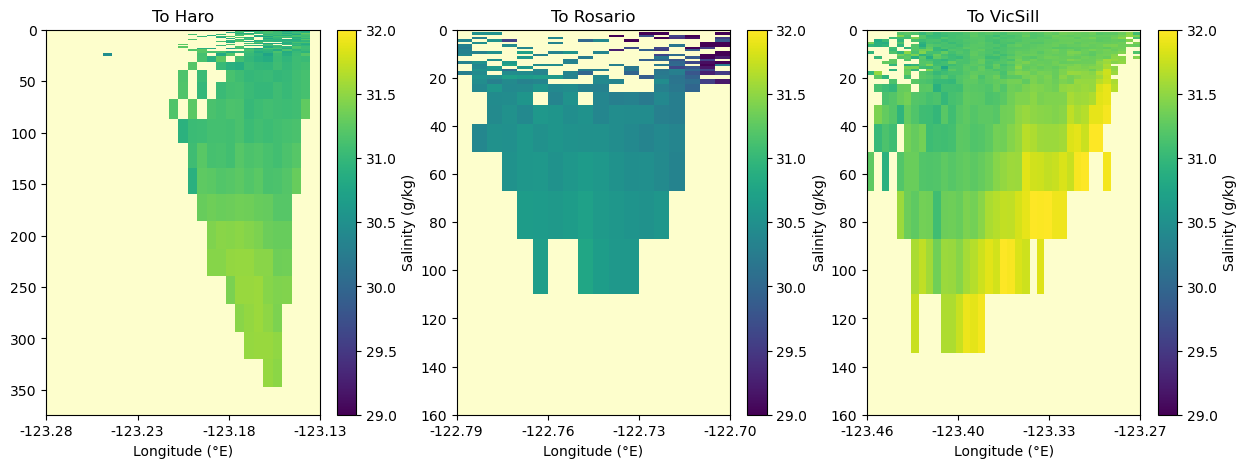

In [55]:
vsfas = get_secdata(datafas,2)
lonWvs = 180
lonEvs = 218

title = 'To Haro'
title2 = 'To Rosario'
title3 = 'To VicSill'

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5))

plotTS(ax1,'sal',harofas['lon'],harofas['z'],harofas['salt'],lonWharo,lonEharo,38,time,title,True,False,vmin=smin,vmax=smax)
plotTS(ax2,'sal',rosfas['lon'],rosfas['z'],rosfas['salt'],lonWros,lonEros,30,time,title2,True,False,vmin=smin,vmax=smax)
plotTS(ax3,'sal',vsfas['lon'],vsfas['z'],vsfas['salt'],lonWvs,lonEvs,30,time,title3,True,False,vmin=smin,vmax=smax)

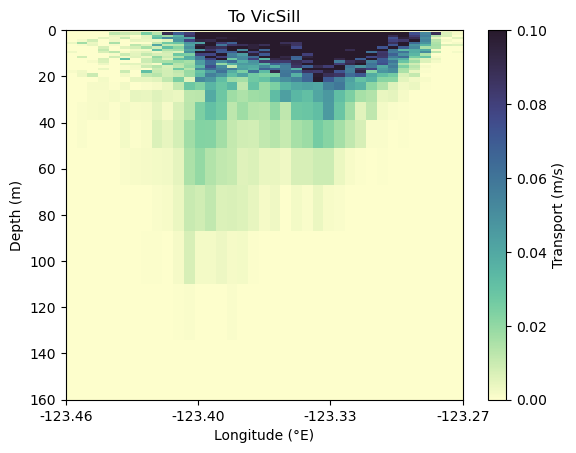

In [56]:
fig,ax = plt.subplots()

title = 'To VicSill'

plotCS(ax,vsfas['lon'],vsfas['z'],vsfas['transport'],lonWvs,lonEvs,30,vmax,time,title,True,True)